# Titanic Survival Random Forest Model

In this notebook I predict the survival of passengers on the titanic.
The dataset is given in the form of two CSV files consisting of tabulated passenger info with no overlap.
The first is the training set of around 800 passengers and test set of around 400 passengers.
There are a total of one indexing column "PassengerId", one target column "Survived", and ten predictor columns.

## Methodology and Goals

My approach was to keep the model and transformations fairly simple, so I chose to apply a **random forest classifier**.
This selection of a RFC was also motivated by the fact that most predictor columns were categorical or could be transformed to categorical data
and the relative sparsity of one column "Cabin."
Initial data exploration demonstrated "Sex" as a good predictor of survival rates.
I expected "Cabin" to be a useful predictor, but only about one-fourth of the entries were filled.
This was remedied by more categorical encoding.

Coding-wise, it was my intention to have Pandas and Scikit-learn do all the heavy-lifting.
A little more polish is needed such as moving some hard-coded parameters outside the functions in which they are define

The final results are 0.83 ACC for the training set and 0.80 ACC for the test set which was my initial hope for total accuracy of such a simple model.

In [1]:
import os
import pandas as pd
import re
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

data_name = "data"
train_bn = "train.csv"
test_bn = "test.csv"
results_bn = "results.csv"

proj_dir = os.path.abspath(
        os.path.join(os.path.abspath(__name__), os.pardir, os.pardir))
data_dir = os.path.join(proj_dir, data_name)
train_fn = os.path.join(data_dir, train_bn)
test_fn = os.path.join(data_dir, test_bn)
results_fn = os.path.join(data_dir, results_bn)

if not os.path.exists(data_dir):
    raise OSError("Data directory not properly setup.")

In [2]:
import sklearn.preprocessing as preprocessing

class LabelEncoderExt(preprocessing.LabelEncoder):
    
    UNK = "UNK"
    
    def __init__(self):
        
        super().__init__()
        
    def fit(self, y):
        
        if not isinstance(y, np.ndarray):
            y = np.array(y)
        assert (len(y.shape) == 1), "Require 1D array"
        y = np.concatenate((y, np.array([self.UNK])))
        super().fit(y)
        
    def transform(self, y):
        
        y[~np.isin(y, self.classes_, assume_unique=True)] = self.UNK
        return super().transform(y)
    
    def fit_transform(self, y):
        
        self.fit(y)
        return self.transform(y)

In [3]:
try: 
    df_train = pd.read_csv(train_fn)
except OSError as e:
    print("Training file missing.")
try:
    df_test = pd.read_csv(test_fn)
except OSError as e:
    print("Test file missing.")

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
name = "Name"
sex = "Sex"
emb = "Embarked"
cabin = "Cabin"
age = "Age"
fare = "Fare"
ticket = "Ticket"
sib = "SibSp"
par = "Parch"
pclass = "Pclass"
ticket_count = "ticket_count"
num_cab = "num_cab"

family = "family"
fam_size = "fam_size"
fam_per_ticket = "fam_per_ticket"
single = "single"
child = "child"

dummy_cols = [
        pclass, 
        fam_size,
        name, 
        cabin, 
        emb,
        num_cab,
        fare,
        age
        ]
pid = "PassengerId"
survived = "Survived"
dep_vars = [survived]
indices = [pid]
ind_vars = [x for x in df_train.columns if x not in (dep_vars+indices+[ticket])]

In [6]:
df_X = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
df_X.head(30)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [8]:
df_train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [9]:
df_test.count()

PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
dtype: int64

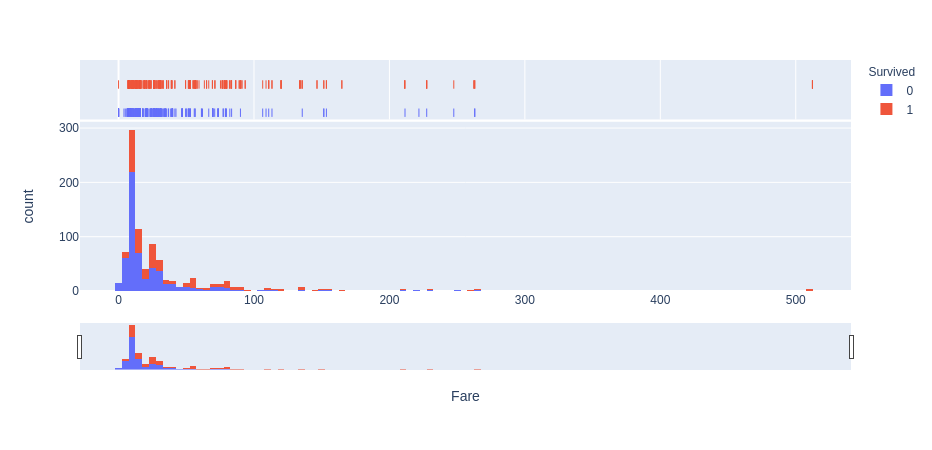

In [10]:
fig = px.histogram(df_train, x=fare, color=survived, marginal="rug", 
    nbins=200, hover_data=df_train.columns
)
fig.update_layout(
    go.Layout(
        xaxis = dict(
            rangeslider = {'visible': True},
        ),
    )
)
iplot(fig)

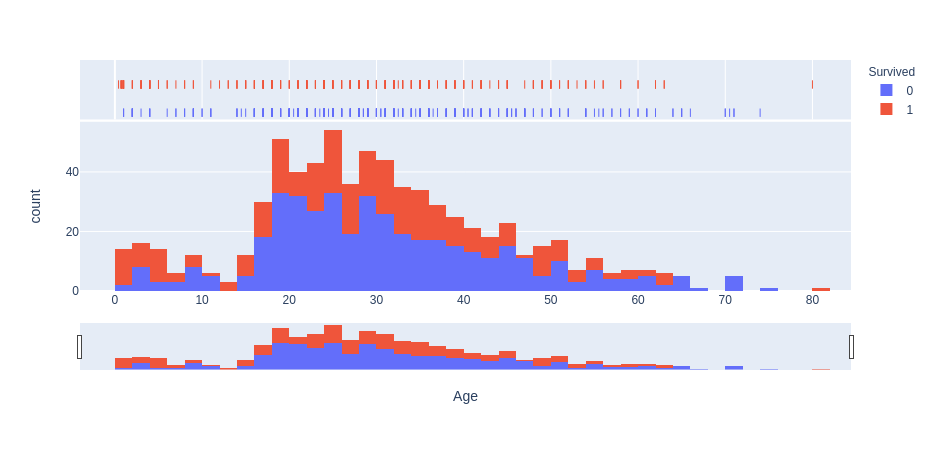

In [11]:
fig = px.histogram(df_train, x=age, color=survived, marginal="rug", 
                               nbins=50, hover_data=df_train.columns)
fig.update_layout(
    go.Layout(
        xaxis = dict(rangeslider={'visible': True},
        ),
    )
)
iplot(fig)

In [12]:
def pre_encoding(df):
    thresh = 0.01
    unk = "UNK"
    reg_ex = "\w+\s?\w*(\.)"
    reg = re.compile(reg_ex)
    cabin_mapping = {'': '', 'A': 'A', 'B': 'B', 'C': 'B',
               'D': 'D', 'E':'D', 'F':'F', 'G': 'F', 'T': 'A'}
    f_size = {1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 
              6: 3, 7: 3, 8: 4, 9: 4, 10: 4, 11: 4}
    
    h = lambda x: x[0] if len(x) > 0 else ''
    df[sex] = df[sex].apply(h)
    
    f = lambda x: x.split(',')[1].strip()
    g = lambda x: reg.match(x).group()
    df[name] = df[name].apply(f).apply(g)
    freq = df[name].value_counts(normalize=True)
    k = lambda x: x if freq[x] >= thresh else unk
    df[name] = df[name].apply(k)
    
    tmp = df.groupby(ticket).count()
    df[ticket_count] = df[ticket].apply(lambda x: tmp.at[x, pid])

    df[cabin] = df[cabin].fillna('')
    numb_cab = lambda x: len(x.split())
    df.loc[df[cabin].notnull(), num_cab] = (
            df.loc[df[cabin].notnull(), cabin].apply(numb_cab)) 
    
    combine_decks = lambda x: cabin_mapping[x]
    df.loc[df[cabin].notnull(), cabin] = (
            df.loc[df[cabin].notnull(), cabin].apply(h).apply(combine_decks))
    
    df[family] = df[par] + df[sib] + 1
    df[fam_per_ticket] = df[family]/df[ticket_count]

    ticket_prefix = lambda x: 1 if (len(x.split())>1) else 0
    df[ticket] = df[ticket].apply(ticket_prefix) 
    
    df[single] = df[family].apply(lambda x: 1 if x==1 else 0)
    
    df[fam_size] = df[family].apply(lambda x: f_size[x])

    return df


def build_encoders(df):
    enc_name = LabelEncoderExt()
    enc_sex = preprocessing.LabelEncoder()
    enc_emb = preprocessing.LabelEncoder()
    enc_cabin = preprocessing.LabelEncoder()

    enc_name.fit(df[name])
    enc_sex.fit(df[sex].dropna())
    enc_emb.fit(df[emb].dropna())
    enc_cabin.fit(df[cabin].dropna())
    enc_dict = {name: enc_name, sex: enc_sex, emb: enc_emb, cabin: enc_cabin}
 
    scl_age = preprocessing.StandardScaler()
    scl_age.fit(df[[age]].dropna().values)
    scl_fare = preprocessing.StandardScaler()
    scl_fare.fit(df[[fare]].dropna().values)
    scl = {age: scl_age, fare: scl_fare}
        
    return enc_dict, scl


def scale(df, scl):
    df.loc[df[age].notnull(), age] = (
            scl[age].transform(df[[age]].dropna().values))
    df.loc[df[fare].notnull(), fare] = (
            scl[fare].transform(df[[fare]].dropna().values))    
    return df


def naive_bayes_data_fill(df, enc_dict):
    df.loc[df[emb].notnull(), emb] = (
            enc_dict[emb].transform(df[emb].dropna().values))
    df.loc[:, sex] = enc_dict[sex].transform(df[sex].values)
    df.loc[df[cabin].notnull(), cabin] = (
            enc_dict[cabin].transform(df[cabin].dropna().values))
    df.loc[:, name] = enc_dict[name].transform(df[name].values)
    
    criteria = [pclass, sex, par] 
    tmp = df[criteria+[emb]].dropna()
    index = df.index.isin(tmp.index)
    
    X = tmp[criteria].values.astype(np.int)
    Y = tmp[emb].values.astype(np.int)
    tmp2 = df.loc[~index, criteria]
    if len(tmp2) > 0:
        clf = MultinomialNB()
        clf.fit(X, Y)
        df.loc[~index, emb] = clf.predict(tmp2)
    
    return df


def mean_data_fill(df):
    group = [pclass, emb]
    nan_fares = df[fare].isnull()
    
    tmp = df.groupby(group).mean()[[fare]]
    tmp2 = df.loc[nan_fares][group]
    ind = pd.MultiIndex.from_arrays(tmp2.values.T, names=tmp.index.names)
    df.loc[nan_fares, fare] = tmp.loc[ind, fare].fillna(0).values
    
    group = [name, pclass, sex]
    nan_ages = df[age].isnull()
    
    tmp1 = df.groupby(group).mean()[[age]]
    tmp2 = df.loc[nan_ages][group]
    ind = pd.MultiIndex.from_arrays(tmp2.values.T, names=tmp1.index.names)
    df.loc[nan_ages, age] = tmp1.loc[ind, age].fillna(0).values

    return df


def discretize(df):
    age_bins = 10
    fare_bins = 6
    df[age] = pd.cut(df_X[age], bins=age_bins, 
                     labels=np.arange(0, age_bins))
    df[fare] = pd.cut(df_X[fare], bins=fare_bins, 
                     labels=np.arange(0, fare_bins))
    return df


def preprocess(df, enc_dict=None, scl=None):
    df = pre_encoding(df)
    if enc_dict is None:
        enc_dict, scl = build_encoders(df)
    df = scale(df, scl)
    df = naive_bayes_data_fill(df, enc_dict)
    
    df = mean_data_fill(df)
    df = discretize(df)
    
    return df, enc_dict, scl

In [13]:
df_X, enc_dict, scl = preprocess(df_X)

In [14]:
df_X.head(30)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ticket_count,num_cab,family,fam_per_ticket,single,fam_size
0,1,0.0,3,2,1,2,1,0,1,0,0,2,1,0,2,2.0,0,1
1,2,1.0,1,3,0,4,1,0,1,0,2,0,2,1,2,1.0,0,1
2,3,1.0,3,1,0,3,0,0,1,0,0,2,1,0,1,1.0,1,0
3,4,1.0,1,3,0,4,1,0,0,0,2,2,2,1,2,1.0,0,1
4,5,0.0,3,2,1,4,0,0,0,0,0,2,1,0,1,1.0,1,0
5,6,0.0,3,2,1,3,0,0,0,0,0,1,1,0,1,1.0,1,0
6,7,0.0,1,2,1,6,0,0,0,0,3,2,2,1,1,0.5,1,0
7,8,0.0,3,0,1,0,3,1,0,0,0,2,5,0,5,1.0,0,2
8,9,1.0,3,3,0,3,0,2,0,0,0,2,3,0,3,1.0,0,1
9,10,1.0,2,3,0,1,1,0,0,0,0,0,2,0,2,1.0,0,1


In [15]:
df_X = df_X.drop([ticket], axis=1)
df_X = df_X.drop([par, sib, family], axis=1)
df_X = df_X.drop([fam_per_ticket], axis=1)

In [16]:
df_train = df_X.iloc[:df_train.shape[0]]
df_test = df_X.iloc[df_train.shape[0]:]

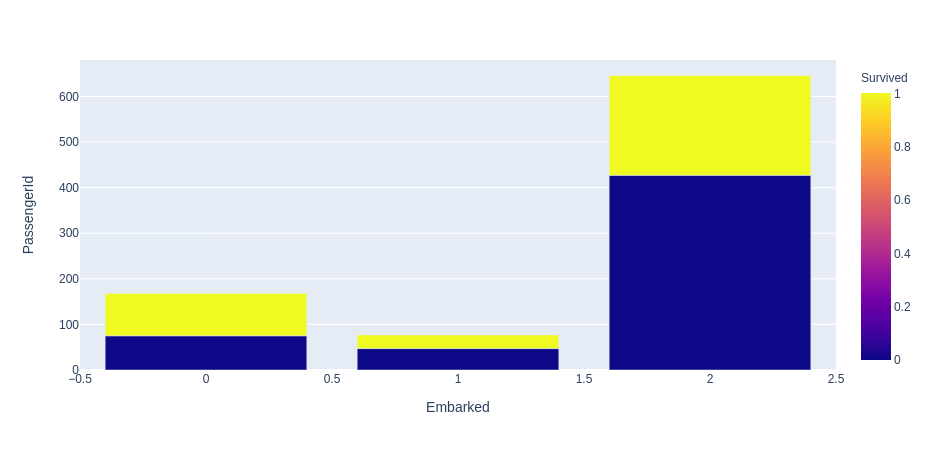

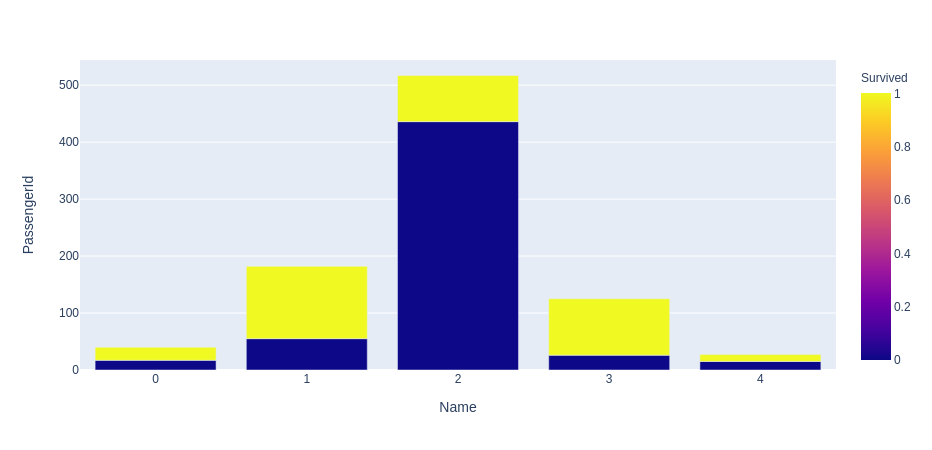

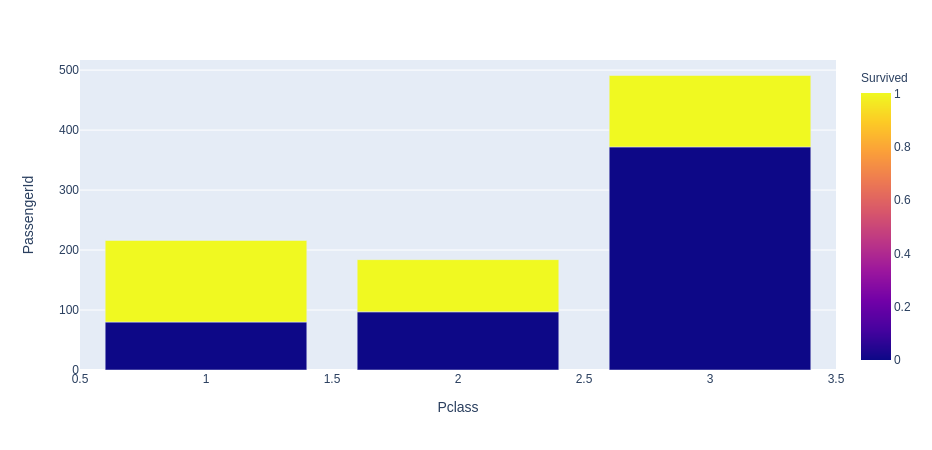

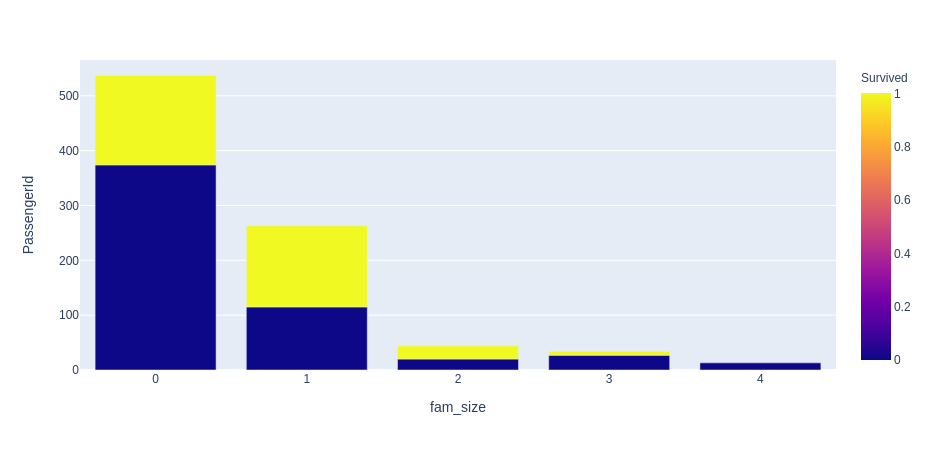

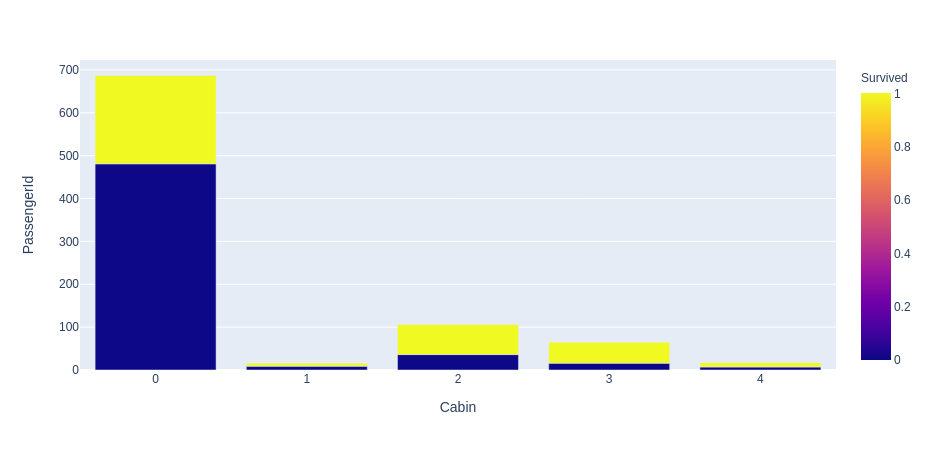

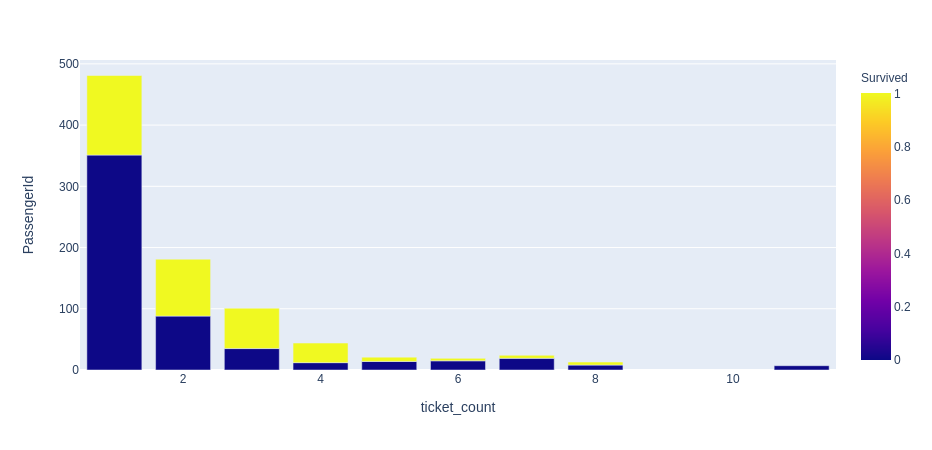

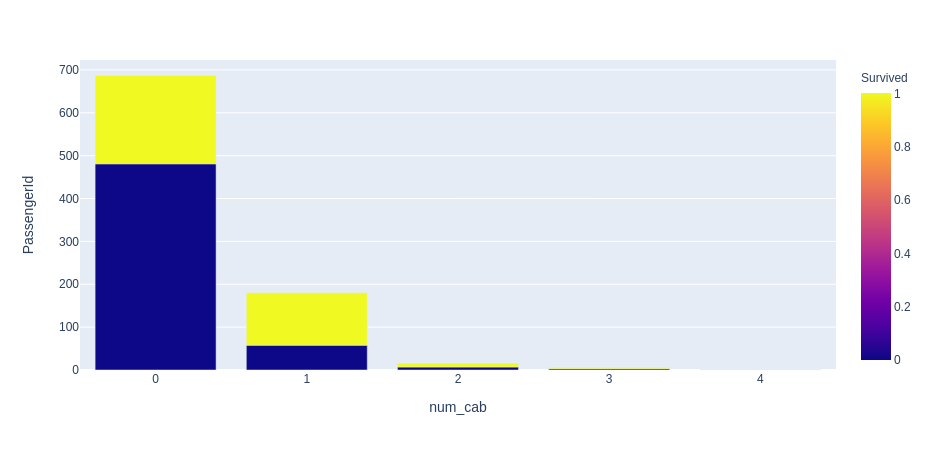

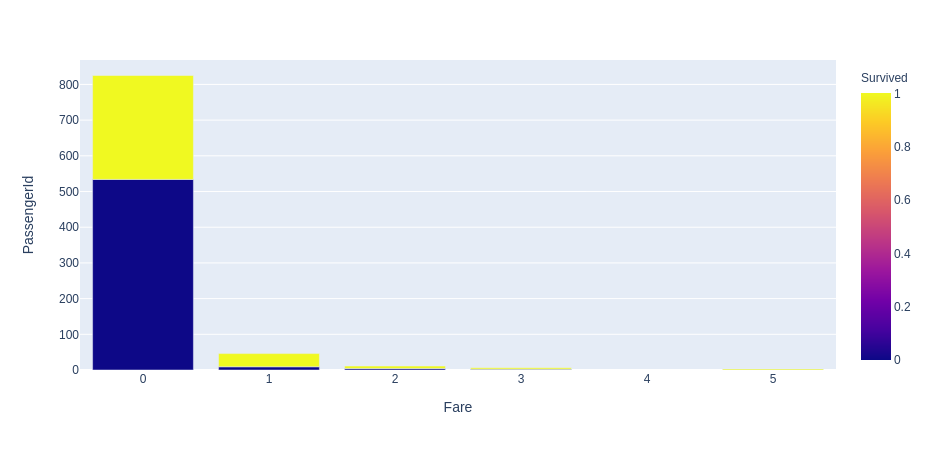

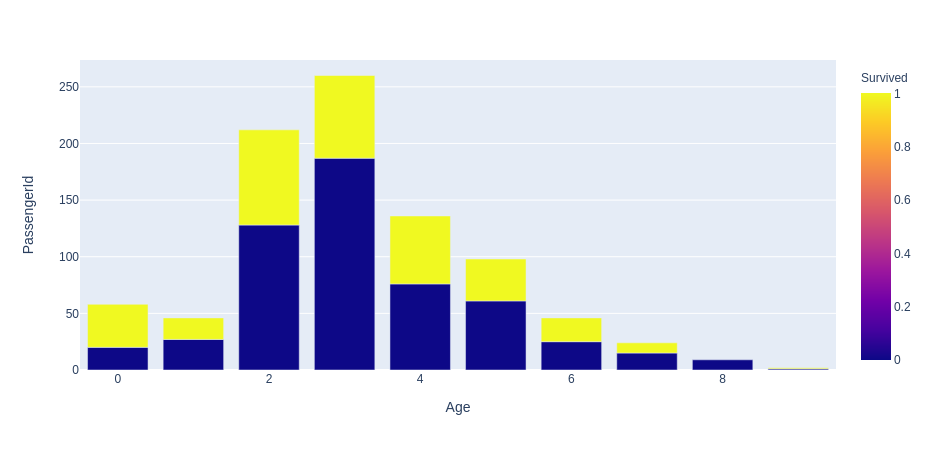

In [17]:
feat_list = [emb, name, pclass, fam_size, cabin,
            ticket_count,
            num_cab,
            fare,
            age,
]

for feat in feat_list:
    df_tmp = df_train.groupby([feat, survived]).count().reset_index()
    fig = px.bar(df_tmp, x=feat, y=pid, color=survived)
    iplot(fig)

In [18]:
X_train = pd.get_dummies(df_train, columns=dummy_cols).drop(dep_vars+indices, axis=1)
X_test = pd.get_dummies(df_test, columns=dummy_cols).drop(indices, axis=1)

X_test = X_test.join(pd.DataFrame({x: 0 for x in X_train.columns if x not in X_test.columns}, index=X_test.index))
X_test = X_test[X_train.columns]

Y_train = df_train[dep_vars]

In [19]:
SEED = 0
np.random.seed(seed=SEED)
clf = RandomForestClassifier(n_estimators=100, max_depth=4,
                            criterion="gini",
                            min_samples_split=3, min_samples_leaf=5)
clf.fit(X_train, Y_train.values.ravel())

pred = clf.predict(X_test)
results = pd.DataFrame({indices[0]: df_test[indices[0]].values, dep_vars[0]: pred}).astype({survived: int})

In [20]:
results.to_csv(results_fn, index=False)

In [21]:
print("Accuracy:", accuracy_score(Y_train, clf.predict(X_train)))
pd.DataFrame(confusion_matrix(Y_train, clf.predict(X_train)))

Accuracy: 0.835016835016835


,0,1
0,497,52
1,95,247


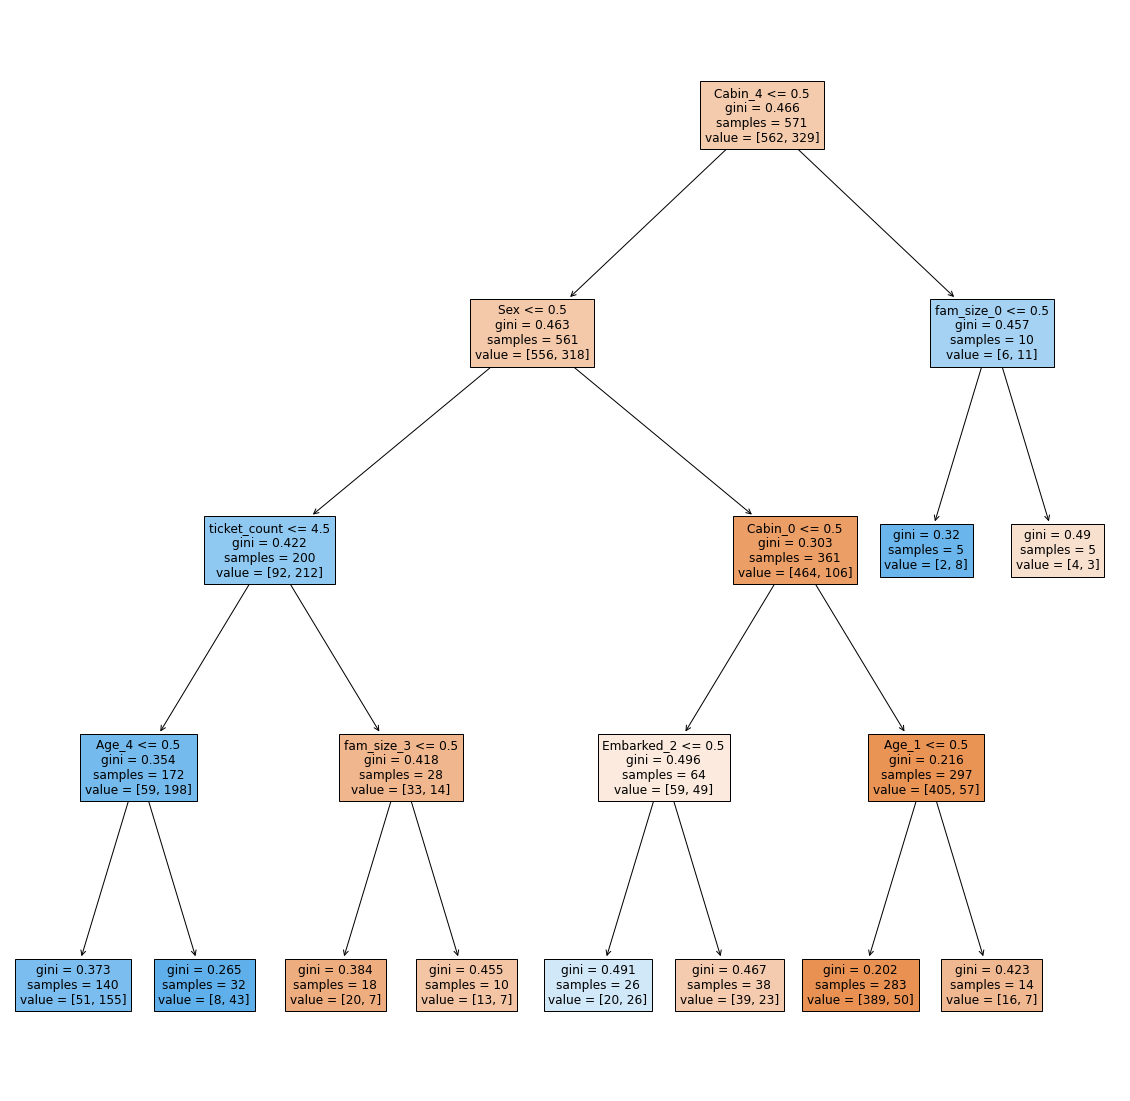

In [22]:
estimator = clf.estimators_[0]

import sklearn.tree as tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot()
a = tree.plot_tree(estimator, feature_names=X_train.columns, filled=True)